## Imports

In [63]:
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics


## Load data

In [13]:
data_xlsx = pd.ExcelFile('data.xlsx')
co2_df = pd.read_excel(data_xlsx, 0)
temp_df = pd.read_excel(data_xlsx, 1)


In [14]:
co2_df.columns = ['year', 'y']
temp_df.columns = ['year', 'y']


## Graphing & Pre-Analysis

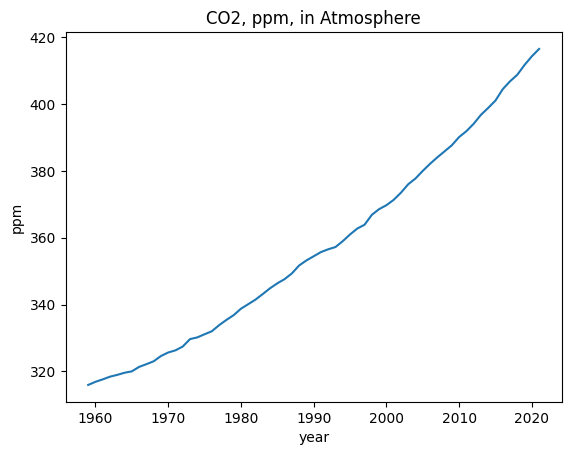

In [16]:
co2_gr = co2_df.plot(x='year', y='y', ylabel='ppm', title='CO2, ppm, in Atmosphere', legend=None)


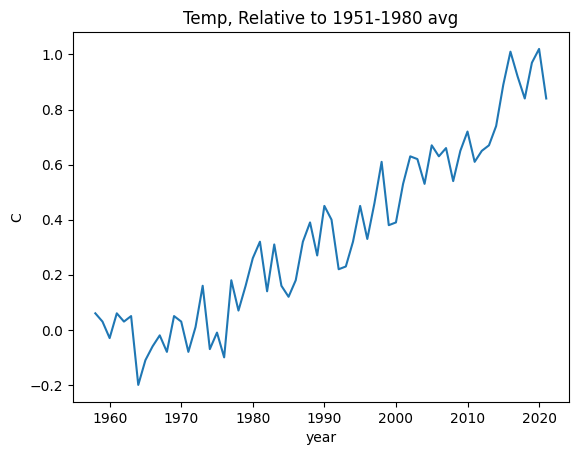

In [17]:
temp_gr = temp_df.plot(x='year', y='y', ylabel='C', title='Temp, Relative to 1951-1980 avg', legend=None)


In [18]:
ct_df = pd.concat([co2_df['y'], temp_df['y']], axis=1, keys=['co2', 'temp'])
ct_df = ct_df[:-1]


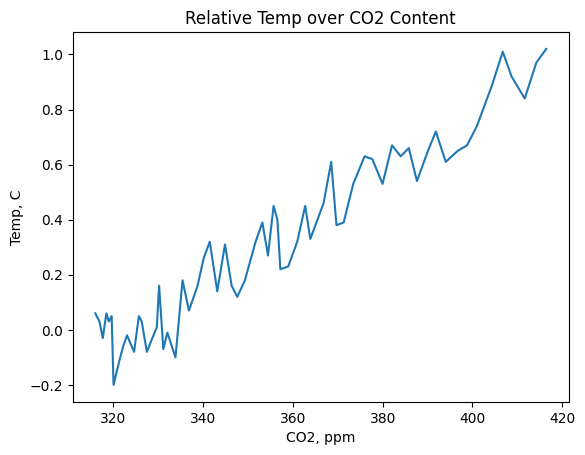

In [19]:
ct_gr = ct_df.plot(x='co2', y='temp', xlabel='CO2, ppm', ylabel='Temp, C', title='Relative Temp over CO2 Content', legend=None)


## Simple Bi variate Analysis

In [54]:
def bivariate_stats(x: pd.Series, y: pd.Series):
        _pmcc = x.corr(y)
        _covr = x.cov(y)

        print(
                f'PMCC: {_pmcc} \n'
                f'R^2:  {_pmcc**2} \n'
                f'Cov:  {_covr}'
        )


def univariate_graphs(x: pd.Series):
        pd.plotting.autocorrelation_plot(x)
        plt.show()


def linear_reg_func(m: LinearRegression):
        _coef = m.coef_[0][0]
        _itcp = m.intercept_[0]
        print(f'Linear Regressed: y = {_coef}x {"+" if abs(_itcp) == _itcp else "-"} {abs(_itcp)}')


### CO2

PMCC: 0.9911930941405609 
R^2:  0.9824637498719389 
Cov:  542.3161290322582


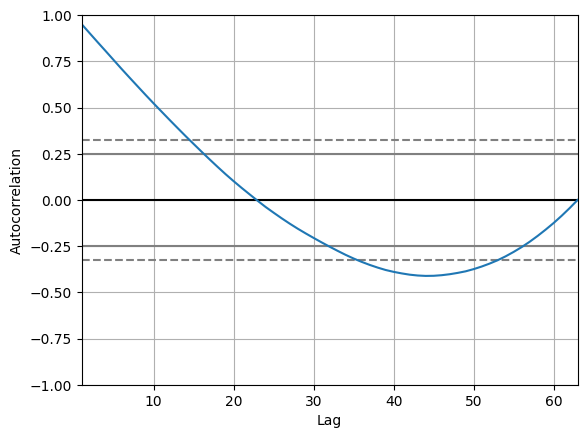

In [55]:
bivariate_stats(co2_df['year'], co2_df['y'])
univariate_graphs(co2_df['y'])

### Temperature

PMCC: 0.9438273888749297 
R^2:  0.8908101399904678 
Cov:  5.706825396825396


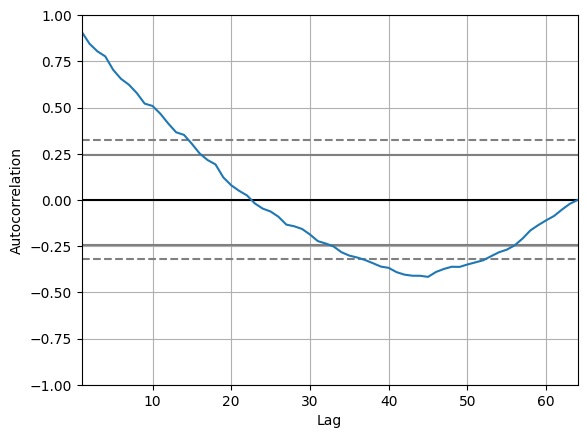

In [56]:
bivariate_stats(temp_df['year'], temp_df['y'])
univariate_graphs(temp_df['y'])

### Temperature over CO2 Content

In [60]:
ct_m_lr = LinearRegression()
ct_m_lr.fit(ct_df[['co2']], ct_df[['temp']])

ct_pred_l = ct_m_lr.predict(ct_df[['co2']])


In [61]:
bivariate_stats(ct_df['co2'], ct_df['temp'])


PMCC: 0.9599812208926523 
R^2:  0.9215639444665472 
Cov:  9.203848156682028


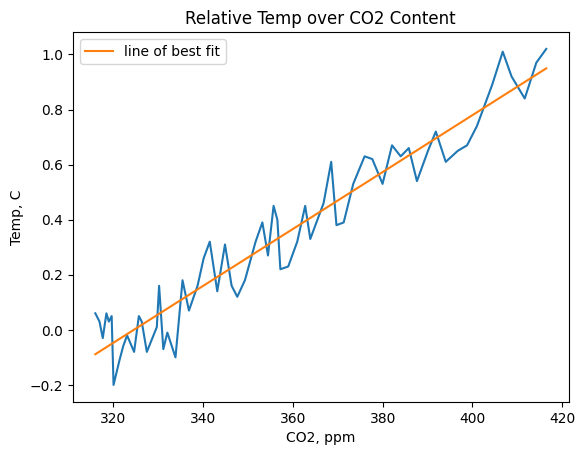

Linear Regressed: y = 0.010330473207293444x - 3.352746379345213


In [62]:
plt.plot(ct_df[['co2']], ct_df[['temp']])
plt.plot(ct_df[['co2']], ct_pred_l, label='line of best fit')
plt.title('Relative Temp over CO2 Content')
plt.ylabel('Temp, C')
plt.xlabel('CO2, ppm')
plt.legend()
plt.show()

linear_reg_func(ct_m_lr)

## CO2 Forecasting

In [111]:
PRED_YEARS = pd.DataFrame(range(1959, 2051))
PRED_YEARS.columns = ['year']

In [78]:
def error_stats(x: pd.Series, y: pd.Series):
        _mse = metrics.mean_squared_error(x, y)
        _mae = metrics.mean_absolute_error(x, y)
        _mape = metrics.mean_absolute_percentage_error(x, y)

        print(
                f'MSE: {_mse} \n'
                f'MAE: {_mae} \n'
                f'MAPE: {_mape}%'
        )

### arima

<AxesSubplot: title={'center': 'CO2 Arima Forecast 2022-2050'}, xlabel='date', ylabel='ppm'>

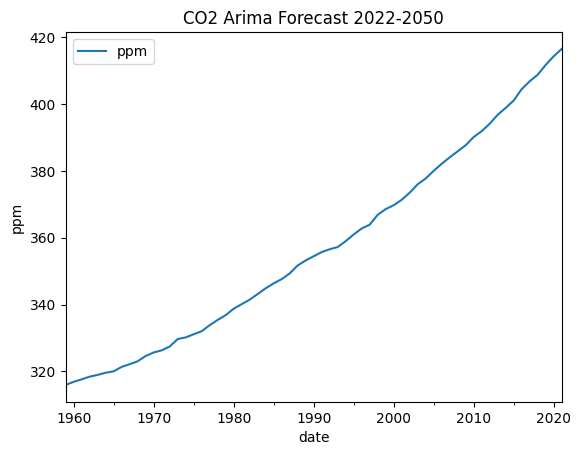

In [24]:
import statsmodels.api as sm
import statsmodels.tsa.statespace.sarimax as sarima
from statsmodels.tsa.stattools import adfuller

co2_arima = co2_df.copy()
co2_arima.columns = ['date', 'ppm']
co2_arima['date'] = pd.to_datetime(co2_arima.date, format='%Y')
co2_arima.plot(x='date', y='ppm', xlabel='date', ylabel='ppm', title='CO2 Arima Forecast 2022-2050')

In [25]:
# p-value NOT <= 0.05 hence it is non-stationary
# Stationarity - The statistical properties of a time series, process generating it do not change overtime
stationary = adfuller(co2_arima['ppm'])
stationary

(5.588259302435865,
 1.0,
 2,
 60,
 {'1%': -3.5443688564814813,
  '5%': -2.9110731481481484,
  '10%': -2.5931902777777776},
 69.40020639043743)

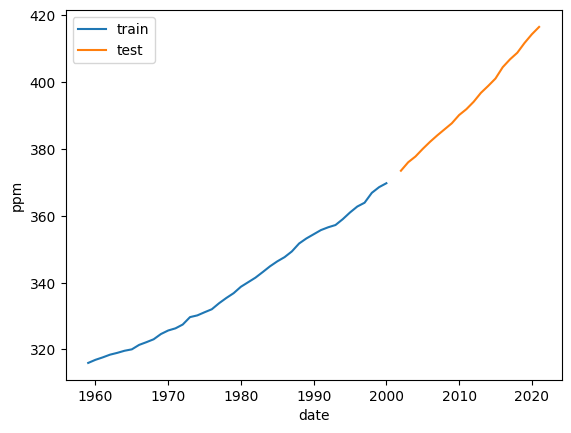

In [26]:
# (this part is for looking at model accuracies later on, ignore for now)
# checking whether first 42 data records can accurately generate last 20 data records
train = co2_arima[:42]
test = co2_arima[-20:]

plt.plot(train['date'], train['ppm'], label='train')
plt.plot(test['date'], test['ppm'], label='test')
plt.xlabel('date')
plt.ylabel('ppm')
plt.legend()

In [27]:
# grid search, exploring different param combinations


### exponential

In [66]:
from scipy.optimize import curve_fit


In [67]:
def expo_func(x, a, b, c, d):
        return a**(x * b + c) + d


In [68]:
pmt, cov = curve_fit(expo_func, co2_df['year'], co2_df['y'])
print(pmt)
print(cov)


[ 1.00571737e+00  2.84266152e+00 -4.85438646e+03  2.56024004e+02]
[[ 1.04860015e+02 -5.19885599e+04  8.87805151e+07 -4.92522722e+00]
 [-5.19885599e+04  2.57754147e+07 -4.40165028e+10  2.44203827e+03]
 [ 8.87805151e+07 -4.40165028e+10  7.51666866e+13 -4.17030800e+06]
 [-4.92518315e+00  2.44201642e+03 -4.17027068e+06  5.91488324e+00]]


In [69]:
co2_pred_exp = expo_func(PRED_YEARS, *pmt)
co2_pred_exp.columns = ['y']

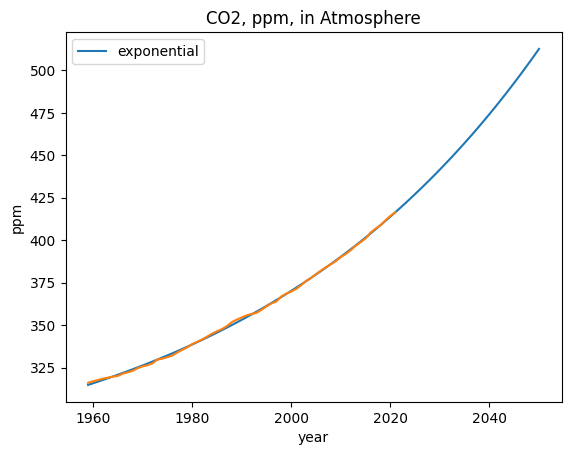

In [70]:
plt.plot(PRED_YEARS, co2_pred_exp, label='exponential')
plt.plot(co2_df[['year']], co2_df[['y']])
plt.title('CO2, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
plt.show()


In [79]:
bivariate_stats(co2_df['y'], co2_pred_exp['y'])
error_stats(co2_df['y'], co2_pred_exp['y'][:63])

print(f'Exponential Regressed: y = {pmt[0]:.6f}^({pmt[1]:.4f}x - {abs(pmt[2]):.1f}) + {pmt[3]:.3f}')

PMCC: 0.9997258887013534 
R^2:  0.9994518525397108 
Cov:  890.4531689383609
MSE: 0.4806155032785782 
MAE: 0.5698107159902743 
MAPE: 0.0016425830680621178%
Exponential Regressed: y = 1.005717^(2.8427x - 4854.4) + 256.024


### prophet

In [80]:
from prophet import Prophet


In [81]:
co2_df2 = co2_df.copy()
co2_df2.columns = ['ds', 'y']
co2_df2['ds'] = pd.to_datetime(co2_df2.ds, format='%Y')


In [82]:
co2_df2

,ds,y
0,1959-01-01,315.98
1,1960-01-01,316.91
2,1961-01-01,317.64
3,1962-01-01,318.45
4,1963-01-01,318.99
...,...,...
58,2017-01-01,406.76
59,2018-01-01,408.72
60,2019-01-01,411.66
61,2020-01-01,414.24


In [83]:
P = Prophet(yearly_seasonality=False)
P.fit(co2_df2)


23:44:08 - cmdstanpy - INFO - Chain [1] start processing
23:44:08 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
future_df = P.make_future_dataframe(periods=30, freq='Y')
future_df


,ds
0,1959-01-01
1,1960-01-01
2,1961-01-01
3,1962-01-01
4,1963-01-01
...,...
88,2046-12-31
89,2047-12-31
90,2048-12-31
91,2049-12-31


In [88]:
forecast_df = P.predict(future_df)
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1959-01-01,316.154264,315.740554,316.563228,316.154264,316.154264,0.0,0.0,0.0,0.0,0.0,0.0,316.154264
1,1960-01-01,316.852419,316.430538,317.263451,316.852419,316.852419,0.0,0.0,0.0,0.0,0.0,0.0,316.852419
2,1961-01-01,317.552487,317.160499,317.990783,317.552487,317.552487,0.0,0.0,0.0,0.0,0.0,0.0,317.552487
3,1962-01-01,318.244058,317.843953,318.641456,318.244058,318.244058,0.0,0.0,0.0,0.0,0.0,0.0,318.244058
4,1963-01-01,318.935629,318.534057,319.362197,318.935629,318.935629,0.0,0.0,0.0,0.0,0.0,0.0,318.935629
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2046-12-31,478.042718,463.922917,490.507613,463.988020,490.560471,0.0,0.0,0.0,0.0,0.0,0.0,478.042718
89,2047-12-31,480.423255,465.518670,493.553770,465.297751,493.572809,0.0,0.0,0.0,0.0,0.0,0.0,480.423255
90,2048-12-31,482.810313,467.088532,496.645857,466.835267,496.739921,0.0,0.0,0.0,0.0,0.0,0.0,482.810313
91,2049-12-31,485.190850,468.467120,499.968579,468.534805,499.798348,0.0,0.0,0.0,0.0,0.0,0.0,485.190850


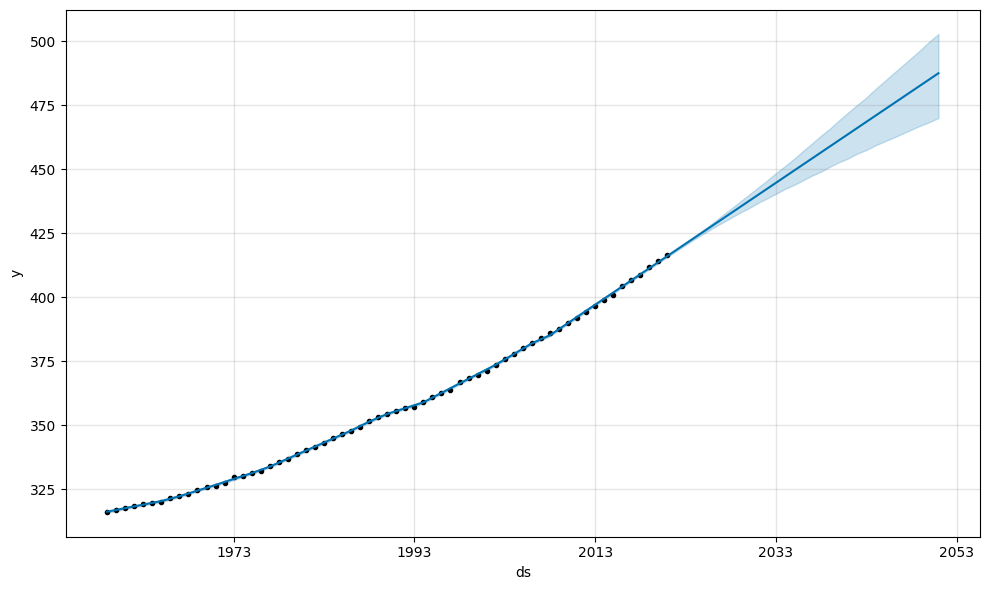

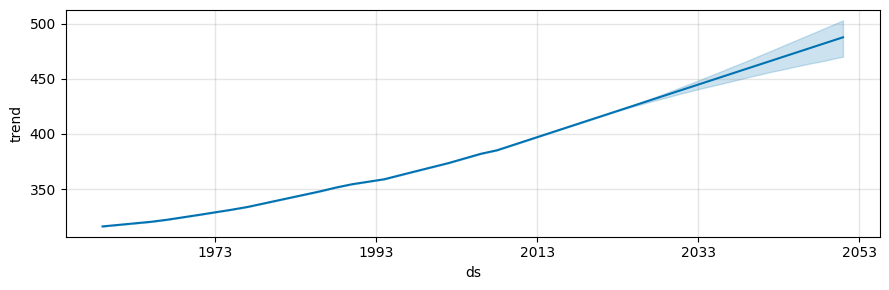

In [89]:
fig = P.plot(forecast_df)
fig2 = P.plot_components(forecast_df)


In [90]:
co2_pred_prophet = forecast_df
co2_pred_prophet = co2_pred_prophet[['ds', 'yhat']]
co2_pred_prophet.columns = ['year', 'y']


In [91]:
bivariate_stats(co2_df['y'], co2_pred_prophet['y'])
error_stats(co2_df['y'], co2_pred_prophet['y'][:63])

PMCC: 0.9999412069035434 
R^2:  0.999882417263715 
Cov:  890.8161713665066
MSE: 0.10309700037217488 
MAE: 0.255074231747799 
MAPE: 0.0007003927564841805%


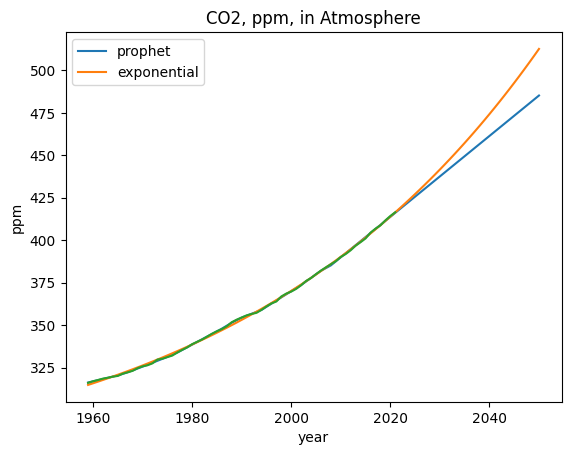

In [92]:
plt.plot(PRED_YEARS, co2_pred_prophet[['y']][:-1], label='prophet')
plt.plot(PRED_YEARS, co2_pred_exp, label='exponential')
plt.plot(co2_df[['year']], co2_df[['y']])
plt.title('CO2, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
plt.show()


## Temperature Predictions

### Linear

In [121]:
m_lr = LinearRegression()
m_lr.fit(temp_df[['year']], temp_df[['y']])

temp_pred_lr = m_lr.predict(PRED_YEARS)
temp_pred_lr = pd.DataFrame(temp_pred_lr)
temp_pred_lr.columns = ['y']

In [126]:
bivariate_stats(temp_df['y'], temp_pred_lr['y'])
error_stats(temp_df[['y']], temp_pred_lr[:64])

PMCC: 0.9438273888749297 
R^2:  0.8908101399904678 
Cov:  0.0939457387784174
MSE: 0.011606344307144485 
MAE: 0.08953735977563988 
MAPE: 1.0192897682818964%
Linear Regressed: y = 0.016461996336996347x - 32.40457921245424


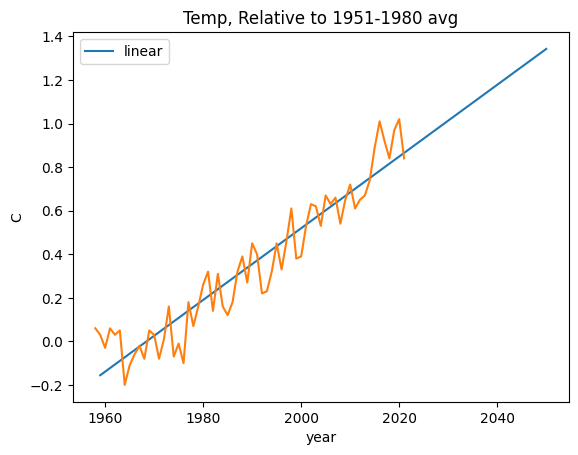

Linear Regressed: y = 0.016461996336996347x - 32.40457921245424


In [127]:
plt.plot(PRED_YEARS, temp_pred_lr, label='linear')
plt.plot(temp_df[['year']], temp_df[['y']])
plt.title('Temp, Relative to 1951-1980 avg')
plt.ylabel('C')
plt.xlabel('year')
plt.legend()
plt.show()

linear_reg_func(m_lr)

### Prophet

In [94]:
M3 = temp_df.copy()
M3.columns = ['ds', 'y']
M3['ds'] = pd.to_datetime(M3.ds, format='%Y')

In [95]:
P = Prophet(yearly_seasonality=False)
P.fit(M3)


23:48:29 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing


In [96]:
future_df = P.make_future_dataframe(periods=30, freq='Y')
forecast_df = P.predict(future_df)


In [97]:
temp_pred_prophet = forecast_df[['ds', 'yhat']]
temp_pred_prophet.columns = ['year', 'y']
temp_pred_prophet

,year,y
0,1958-01-01,-0.170764
1,1959-01-01,-0.154395
2,1960-01-01,-0.138025
3,1961-01-01,-0.121610
4,1962-01-01,-0.105240
...,...,...
89,2046-12-31,1.295877
90,2047-12-31,1.312397
91,2048-12-31,1.328962
92,2049-12-31,1.345482


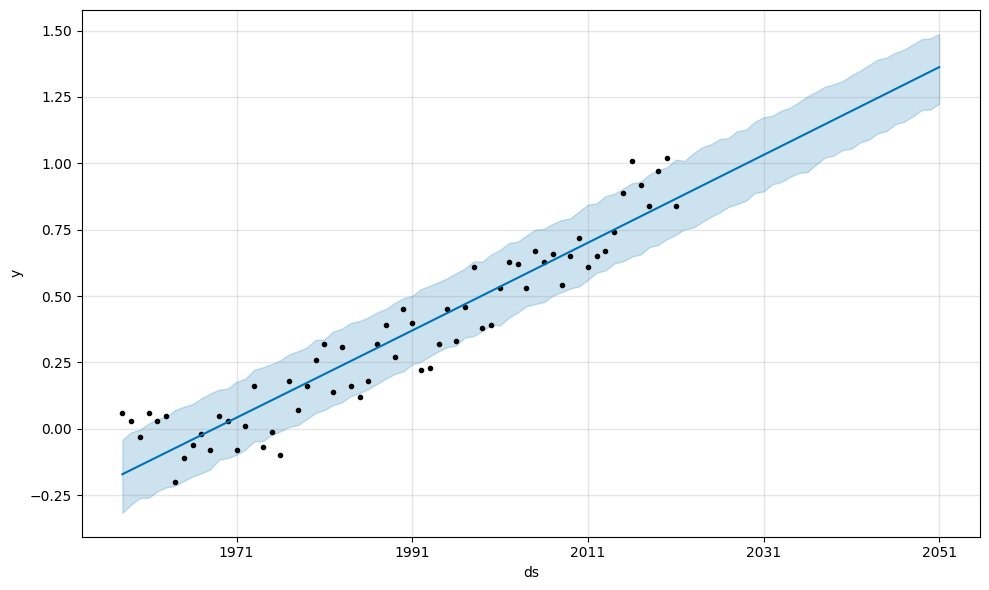

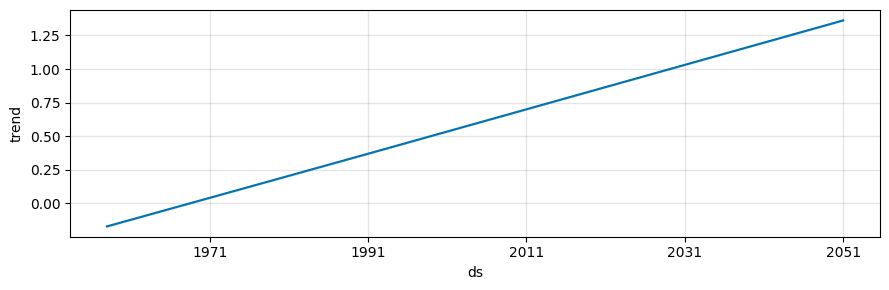

In [98]:
fig3 = P.plot(forecast_df)
fig4 = P.plot_components(forecast_df)

In [100]:
bivariate_stats(temp_df['y'], temp_pred_prophet['y'])
error_stats(temp_df['y'], temp_pred_prophet['y'][:64])

PMCC: 0.9441398200537549 
R^2:  0.8913999998111366 
Cov:  0.0939633080438092
MSE: 0.011274132622671205 
MAE: 0.08830650411782895 
MAPE: 0.9677051803543708%


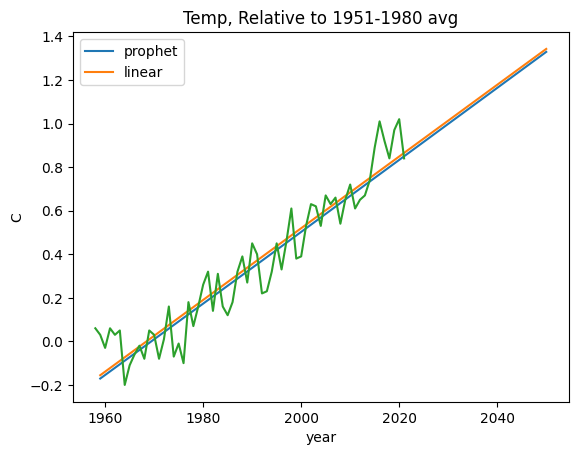

In [125]:
plt.plot(PRED_YEARS, temp_pred_prophet[['y']][:-2], label='prophet')
plt.plot(PRED_YEARS, temp_pred_lr, label='linear')
plt.plot(temp_df[['year']], temp_df[['y']])
plt.title('Temp, Relative to 1951-1980 avg')
plt.ylabel('C')
plt.xlabel('year')
plt.legend()
plt.show()
